In [2]:
import torch
from torch import nn
import torchvision
from torchvision import transforms 
import os
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
# скачать датасет - https://www.kaggle.com/datasets/tongpython/cat-and-dog

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [24]:
weights = torchvision.models.ViT_B_16_Weights.DEFAULT
effnetb0 = torchvision.models.vit_b_16(weights=weights)
trans_effnet = weights.transforms()
for param in effnetb0.parameters():
    param.requires_grad = False


In [25]:
from torchinfo import summary
effnetb0.heads = nn.Sequential(
    nn.Linear(768, 2).to(device=device)
)
optimizer = torch.optim.Adam(effnetb0.parameters(), lr=0.001)
summary(effnetb0, (32, 3, 224, 224), col_names=['input_size', 'output_size', 'num_params', 'trainable'], col_width=20, row_settings=['var_names'])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [32, 3, 224, 224]    [32, 2]              768                  Partial
├─Conv2d (conv_proj)                                         [32, 3, 224, 224]    [32, 768, 14, 14]    (590,592)            False
├─Encoder (encoder)                                          [32, 197, 768]       [32, 197, 768]       151,296              False
│    └─Dropout (dropout)                                     [32, 197, 768]       [32, 197, 768]       --                   --
│    └─Sequential (layers)                                   [32, 197, 768]       [32, 197, 768]       --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [32, 197, 768]       [32, 197, 768]       (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [32, 197, 768]       [32, 

In [7]:
class Dataset2classes(torch.utils.data.Dataset):
    def __init__(self, dir1, dir2):
        self.dir1 = dir1
        self.dir2 = dir2
        self.class1 = sorted(os.listdir(dir1))
        self.class2 = sorted(os.listdir(dir2))
        self.classes = [dir1.split('/')[-1], dir2.split('/')[-1]]
    
    def __len__(self):
        return len(self.class1) + len(self.class2)
    
    def __getitem__(self, idx):
        if idx < len(self.class1):
            img = trans_effnet(Image.open(os.path.join(self.dir1, self.class1[idx])))
            lbl = 0
        else:
            img = trans_effnet(Image.open(os.path.join(self.dir2, self.class2[idx - len(self.class1)])))
            lbl = 1
        return img, lbl
    
    def __repr__(self):
        return f"2 classes dataset \n{len(self)} - samples\n{self.classes} - class names"

train_ds = Dataset2classes("data/train/cats", "data/train/dogs")
test_ds = Dataset2classes("data/test/cats", "data/test/dogs")
train_ds

2 classes dataset 
8005 - samples
['cats', 'dogs'] - class names

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.141793..2.64].


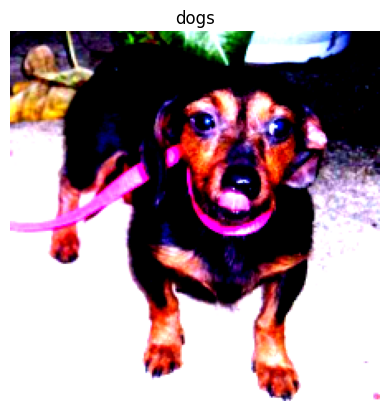

In [8]:
import random
indx = random.randint(0, len(test_ds))
plt.title(test_ds.classes[test_ds[indx][1]]);
plt.imshow(test_ds[indx][0].permute(1, 2, 0));
plt.axis(False);

In [9]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_ds, 32, True)
test_dataloader = DataLoader(test_ds, 32, False)

In [10]:
len(train_dataloader)

251

In [21]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.0001, betas=(0.9, 0.999))

In [12]:
train_ds[0][0].shape

torch.Size([3, 224, 224])

In [19]:
def accuracy_score(y, y_pred):
    return torch.sum(y == y_pred) / len(y_pred) * 100

In [26]:
from tqdm import tqdm

effnetb0 = effnetb0.to(device)
EPOCHS = 1
for epoch in range(EPOCHS):
    train_loss, train_acc = 0, 0
    test_loss, test_acc = 0, 0
    for X, y in train_dataloader:
        X, y = X.to(device), y.to(device)
        effnetb0.train()
        with torch.autocast(device):
            y_pred = effnetb0(X)
            loss = loss_fn(y_pred, y)
        acc = accuracy_score(y, y_pred.argmax(1))
        train_loss += loss
        train_acc += acc
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    for X, y in test_dataloader:
        X, y = X.to(device), y.to(device)
        effnetb0.eval()
        with torch.inference_mode():
            y_pred = effnetb0(X)
            loss = loss_fn(y_pred, y)
        acc = accuracy_score(y, y_pred.argmax(1))
        test_loss += loss
        test_acc += acc
    print(f'EPOCH: {epoch}')
    print(f'train: acc - {train_acc / len(train_dataloader)}% loss - {train_loss / len(train_dataloader)}')
    print(f'test: acc - {test_acc / len(test_dataloader)}% loss - {test_loss / len(test_dataloader)}')
    print()

EPOCH: 0
train: acc - 98.30677795410156% loss - 0.060962896794080734
test: acc - 99.4140625% loss - 0.025672368705272675



tensor([[0.9345, 0.0655]], device='cuda:0', grad_fn=<SoftmaxBackward0>)


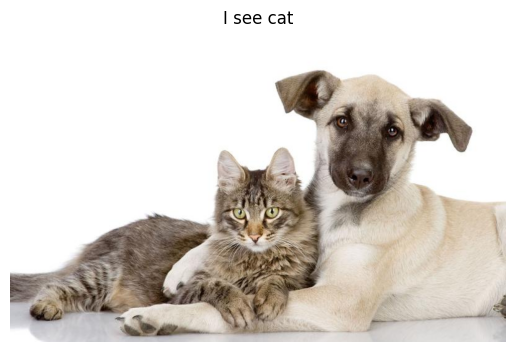

In [50]:
img_test = Image.open('my_photos/17.jpg')
img_test_trans = trans_effnet(img_test).to(device)
plt.imshow(img_test);
plt.axis(False);
plt.title(f"I see {train_ds.classes[effnetb0(img_test_trans.unsqueeze(0)).argmax(1)][:-1]}");
print(effnetb0(img_test_trans.unsqueeze(0)).softmax(1))

### SAVE

In [46]:
from pathlib import Path

torch.save(effnetb0.state_dict(), f="models/model_0.pth")

### LOAD


In [ ]:
weights = torchvision.models.ViT_B_16_Weights.DEFAULT
model_new = torchvision.models.vit_b_16(weights=weights)
model_new.load_state_dict(torch.load(f="models/model_0.pth"))

### 


tensor([[0.0839, 0.9161]], grad_fn=<SoftmaxBackward0>)


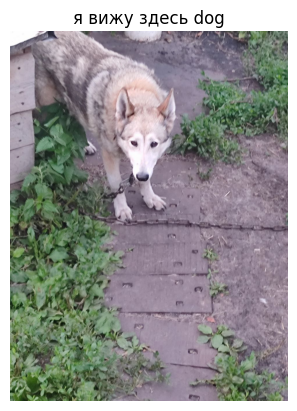

In [14]:
img_test = Image.open('my_photos/1.jpg')
img_test_trans = trans_effnet(img_test)
plt.imshow(img_test);
plt.axis(False);
plt.title(f"я вижу здесь {train_ds.classes[model_new(img_test_trans.unsqueeze(0)).argmax(1)][:-1]}");
print(model_new(img_test_trans.unsqueeze(0)).softmax(1))